In [48]:
from glob import glob
import uproot as ur
import numpy as np
import json, os
import os.path as osp
from tqdm.auto import tqdm
from typing import Optional
from json import load
from phc import module_reload, plot_hist
module_reload('zhh')
from zhh import parse_sample_path, get_preselection_passes, ProcessIndex, \
    get_chunks_factual, EventCategories, sample_weight, presel_stack, \
    parse_json, get_pol_key, get_final_state_counts, fig_ild_style, \
    plot_preselection_by_event_category, \
    plot_preselection_by_event_categories, \
    calc_preselection_by_event_categories
version = 'v1'

REPO_ROOT = '/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/ZHH' if os.name != 'nt' else 'C:/DevRepositories/ZHH'
DATA_ROOT = f'/nfs/dust/ilc/user/bliewert/zhh'
INDEX_DIR = '/nfs/dust/ilc/user/bliewert/zhh/CreateRawIndex/v1'

processes = np.load(f"{INDEX_DIR if os.name != 'nt' else REPO_ROOT}/processes.npy")
samples = np.load(f"{INDEX_DIR if os.name != 'nt' else REPO_ROOT}/samples.npy")
chunks = np.load(f'{DATA_ROOT}/CreatePreselectionChunks/v1/chunks.npy') if os.name != 'nt' else np.load(f'{REPO_ROOT}/chunks_f.npy')

Validate chunks

In [4]:
subset = chunks_f[chunks_f['chunk_size_factual'] <= 0]
if len(subset) > 0:
    raise Exception(f"Invalid chunk length mismatch for branch <{subset['branch']}>")
else:
    print('Chunks OK')

Chunks OK


Introduce indices on samples and processes (included in future runs)

In [12]:
dtype_sample = ProcessIndex.dtype_sample
dtype_process = ProcessIndex.dtype_process

if not 'sid' in samples.dtype.names:
    samples_new = np.empty(len(samples), dtype=dtype_sample)
    samples_new['sid'] = np.arange(len(samples))
    for col in samples.dtype.names:
        samples_new[col] = samples[col]
        
    if len(samples) == len(samples_new):
        np.save(f'{INDEX_DIR}/samples.npy', samples_new)

if not 'pid' in processes.dtype.names:
    #processes_new = np.array([pids, *(processes[col] for col in processes.dtype.names)], dtype=dtype_process)
    processes_new = np.empty(len(processes), dtype=dtype_process)
    processes_new['pid'] = np.arange(len(processes))
    for col in processes.dtype.names:
        processes_new[col] = processes[col]

    if len(processes) == len(processes_new):
        np.save(f'{INDEX_DIR}/processes.npy', processes_new)
        
print('Conversion successful')

Conversion successful


Prototyping

In [15]:
from ast import literal_eval as make_tuple
import json

def test_meta_files(DATA_ROOT:str=f'{DATA_ROOT}/PreselectionFinal/{version}')->bool:
    files = glob(f'{DATA_ROOT}/*_Source.txt')
    #branches = list(map(lambda x: x.split(f'{DATA_ROOT}/')[1].split('_Source.txt')[0], files))

    for f in tqdm(files):
        branch = f.split(f'{DATA_ROOT}/')[1].split('_Source.txt')[0]
        
        if osp.isfile(f'{DATA_ROOT}/{branch}_FinalStateMeta.json'):
            with open(f, 'r') as file:
                src_spec = file.read()
                if src_spec.startswith('('):
                    src_file, chunk_start, chunk_end = make_tuple(src_spec)
                else:
                    src_file = src_spec
            
            # Read metadata
            with open(f'{DATA_ROOT}/{branch}_FinalStateMeta.json', 'r') as file:
                meta = json.load(file)

            n_gen = meta['nEvtSum']
            proc = meta["processName"]
            
            if proc == '' or n_gen == 0:
                print(src_file)
                raise Exception(branch)
    
    return True

In [ ]:
test_meta_files()

Preselection Detailed

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
category_map = { key:value for key, value in EventCategories.EVENT_CATEGORY_TRUE.__dict__.items() if not key.startswith('__') and not callable(key)}
category_map_inv = { v: k for k, v in category_map.items() }

category_arr = np.zeros(len(category_map_inv.keys()), dtype=[('evt_cat', 'I'), ('name', '<U16')])
category_arr['evt_cat'] = list(category_map_inv.keys())
category_arr['name'] = list(category_map_inv.values())

mode = 'load'
save = False

if mode == 'prod':
    DATA_R = f'{DATA_ROOT}/PreselectionFinal/{version}'
    branches = [14336]
    presel = 'llHH'
elif mode == 'debug':
    DATA_R = f'{REPO_ROOT}/output'
    branches = ['zhh']
    presel = 'llHH'

#get_final_state_counts(DATA_R, branches, chunks_f)

In [115]:
module_reload('zhh')
from zhh import presel_stack

if mode == 'prod' or mode == 'prod-debug':
    chunks_f = get_chunks_factual(f'{DATA_ROOT}/PreselectionFinal/{version}', chunks_in=chunks) if os.name != 'nt' else chunks

if mode == 'prod-debug':
    # create PreselectionSummary results here
    presel_results = presel_stack(f'{DATA_ROOT}/PreselectionFinal/{version}', processes, chunks_f, [0,1])#chunks['branch'])
elif mode == 'prod':
    # use PreselectionSummary results        
    files = glob(f'/nfs/dust/ilc/user/bliewert/zhh/PreselectionSummary/v1/[0-9]*.npy')
    size_tot = chunks_f['chunk_size_factual'].sum()
    presel_results = None
    pointer = 0

    for file in tqdm(files):
        part = np.load(file)
        if presel_results is None:
            presel_results = np.zeros(size_tot, dtype=part.dtype)
            
        presel_results[pointer:(pointer+len(part))] = part
        pointer += len(part)
    
elif mode == 'debug':
    branch = 'zhh'
    meta = parse_json(f'{REPO_ROOT}/output/{branch}_FinalStateMeta.json')
    
    chunks_f_deb = np.zeros(1, dtype=[('branch', f'<U{len(branch)}'), ('proc_pol', '<U32'), ('chunk_size_factual', 'I')])
    chunks_f_deb['branch'] = 'zhh'
    chunks_f_deb['proc_pol'] = f"{meta['processName']}_{get_pol_key(meta['polElectron'], meta['polPositron'])}"
    chunks_f_deb['chunk_size_factual'] = meta['nEvtSum']
    
    presel_results = presel_stack(f'{REPO_ROOT}/output', processes, chunks_f_deb, [branch], kinematics=True)
elif mode == 'load':
    presel_results = np.load(f'{REPO_ROOT if os.name == "nt" else DATA_ROOT}/presel_results.npy')

if mode != 'load':
    # Calculate weights
    pids = np.unique(presel_results['pid'])
    weights = np.zeros(len(pids), dtype=[('pid', 'H'), ('weight', 'f')])
    weights['pid'] = pids

    for pid in tqdm(pids):
        process = processes[processes['pid'] == pid][0]
        pol_em, pol_ep = process['pol_e'], process['pol_p']
        cross_sec = process['cross_sec']
        
        n_gen = np.sum(presel_results['pid'] == pid)
        
        weights['weight'][weights['pid'] == pid] = sample_weight(cross_sec, (pol_em, pol_ep), n_gen)
else:
    weights = np.load(f'{REPO_ROOT if os.name == "nt" else DATA_ROOT}/presel_weights.npy')
    chunks_f = np.load(f'{REPO_ROOT if os.name == "nt" else DATA_ROOT}/chunks_f.npy')
    
if save == True:
    np.save(f'{DATA_ROOT}/presel_results.npy', presel_results)
    np.save(f'{DATA_ROOT}/presel_weights.npy', weights)
    np.save(f'{REPO_ROOT if os.name == "nt" else DATA_ROOT}/chunks_f.npy', chunks_f)

In [42]:
module_reload('phc')
module_reload('zhh')
from phc import plot_hist
from zhh import fig_ild_style, plot_preselection_by_event_categories

In [43]:
from typing import List, Union, Iterable
from matplotlib.figure import Figure

def plot_cut_efficiency(presel_results:np.ndarray, masks:List[np.ndarray], weights:np.ndarray, signal_categories:List[int],
                        category_map_inv:dict, processes:np.ndarray,
                        quantity:str, xunit:str, event_categories:Optional[List[int]]=None, additional_event_categories:int=2,
                        with_sbr:bool=True,
                        xlim:Optional[tuple]=None, yscale:str='log', nbins:Union[int,Iterable[int]]=100, ild_style_kwargs:dict={}, xlabel:Optional[str]=None)->List[Figure]:
    all_figs = []
    subsets = []
    for mask in masks:
        subsets.append(presel_results[mask])
    
    subset_pre = subsets[0]
    subset_end = subsets[-1]

    mask_pre_cat = np.isin(subset_pre['event_category'], signal_categories)
    mask_end_cat   = np.isin(subset_end['event_category'], signal_categories)

    weights_pre  = weights['weight'][subset_pre[mask_pre_cat]['pid']]
    weights_post = weights['weight'][subset_end[mask_end_cat]['pid']]

    signal_eff = np.sum(weights_post)/np.sum(weights_pre)
    
    if with_sbr:
        SBR_pre  = np.sum(weights_pre) /weights['weight'][subset_pre[~mask_pre_cat]['pid']].sum()
        SBR_end = np.sum(weights_post)/weights['weight'][subset_end[~mask_end_cat]['pid']].sum()
    
    for i, subset in enumerate([subset_pre, subset_end]):
        with_cuts = i > 0
        if with_cuts:
            title_postfix = r' $\bf{with}$ cuts @ ' + rf'{signal_eff*100:0.1f}% eff.'
        else:
            title_postfix = r' $\bf{without}$ cuts'
        
        if with_sbr:
            title_postfix += rf'; SBR={(SBR_end if with_cuts else SBR_pre):.2E}'
        
        figs = plot_preselection_by_event_categories(subset, processes, weights, category_map_inv, 'llHH', True,
                                            event_categories=event_categories, additional_event_categories=additional_event_categories,
                                        quantity=quantity, check_pass=False, plot_flat=False, unit=xunit, xlim=(xlim[i] if isinstance(xlim, list) else xlim),
                                        xlabel=quantity if xlabel is None else xlabel, yscale=yscale,
                                        ild_style_kwargs={
                                            'ild_offset_x': 0.55,
                                            'title_postfix': title_postfix
                                        } | ild_style_kwargs, nbins=(nbins[i] if isinstance(nbins, list) else nbins))
        for fig in figs:
            all_figs.append(fig)
        
        
        
    return all_figs

In [65]:
from matplotlib.figure import Figure
from typing import Generator

def generate_cuts_ll(presel_results:np.ndarray,
                     mH:float=125., mH_maxDiff:float=60.,
                     mZ:float=91.2, mZ_maxDiff:float=40.)->Generator[np.ndarray,np.ndarray,np.ndarray]:
    
    a = ( presel_results['xx_nisoleps'] >= 2 )
    yield a
    
    a = a & ( np.abs(presel_results['ll_mz'] - mZ) < mZ_maxDiff )
    yield a
    
    a = a & ( np.abs(presel_results['ll_mh1'] - mH) < mH_maxDiff ) & ( np.abs(presel_results['ll_mh2'] - mH) < mH_maxDiff )
    yield a

def plot_lepton_preselection(presel_results:np.ndarray, weights:np.ndarray, category_map_inv:dict, processes:np.ndarray,
                             event_categories:List[int]=[11, 16, 12, 13, 14],ild_style_kwargs:dict={})->List[Figure]:
    all_figs = []
    
    signal_categories = [11]

    mask_start = np.ones(len(presel_results), dtype=bool) # (presel_results['ll_mz'] > 0)
    
    # n_isolep, mZ, mH1, mH2
    qoi = [
        ('xx_nisoleps', None, 'iso leptons', None, 4),
        ('ll_mz', 'GeV', 'm_Z', [(0, 650.), None], 100),
        ('ll_mh1', 'GeV', 'm_{H1}', [(0, 450.), None], [100, 32]),
        ('ll_mh2', 'GeV', '{m_H2}', [(0, 450.), None], [100, 32]),
    ]
    
    for i, cut_mask in enumerate(generate_cuts_ll(presel_results)):
        quantity, xunit, xlabel, xlim, nbins = qoi[i]
        
        for fig in plot_cut_efficiency(presel_results, [mask_start, cut_mask], weights, signal_categories, category_map_inv, processes,
                                    quantity, xunit, event_categories=event_categories, xlabel=xlabel, nbins=nbins, xlim=xlim):
            all_figs.append(fig)
    
    return all_figs

xx_nisoleps None iso leptons None 4


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

ll_mz GeV m_Z [(0, 650.0), None] 100


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

ll_mh1 GeV m_H1 [(0, 450.0), None] [100, 32]


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[<Figure size 800x600 with 1 Axes>,
 <Figure size 800x600 with 1 Axes>,
 <Figure size 800x600 with 1 Axes>,
 <Figure size 800x600 with 1 Axes>,
 <Figure size 800x600 with 1 Axes>,
 <Figure size 800x600 with 1 Axes>]

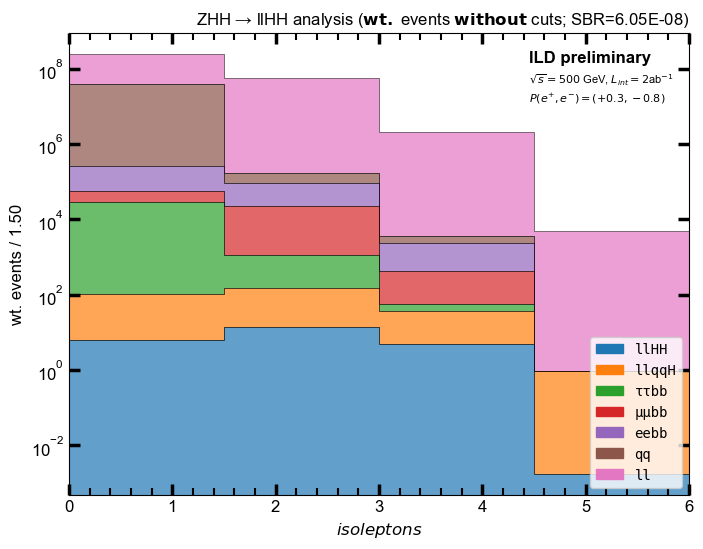

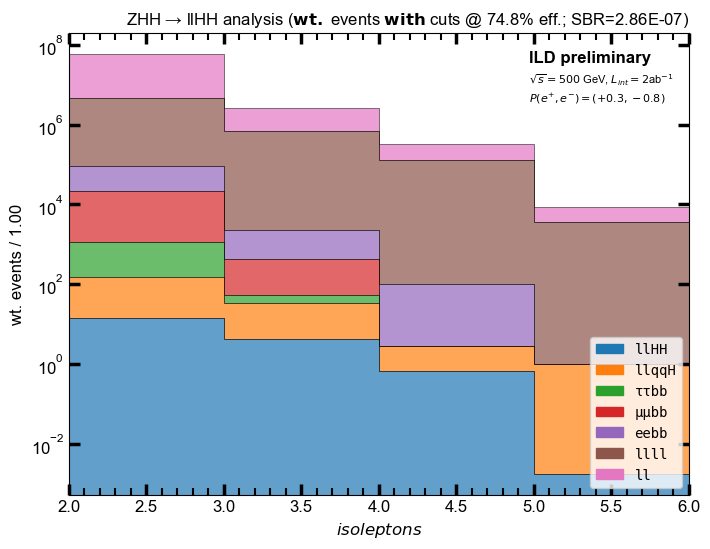

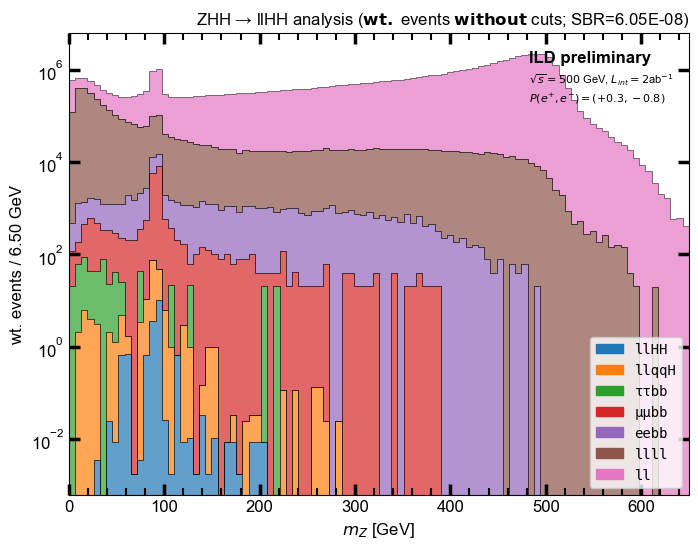

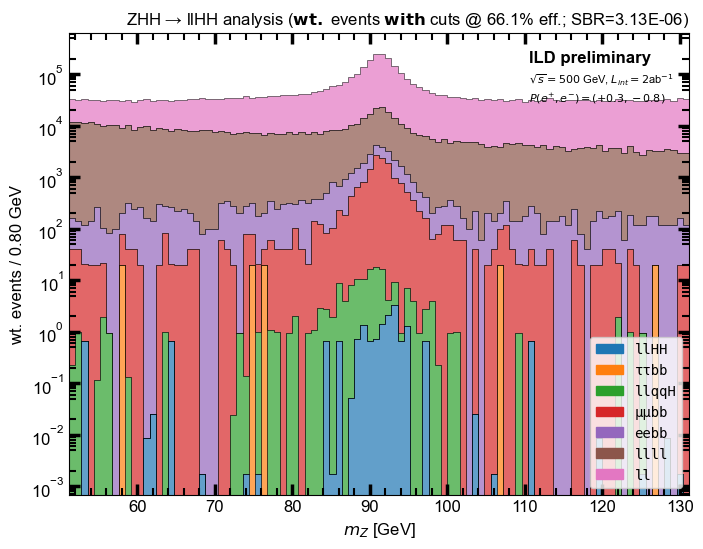

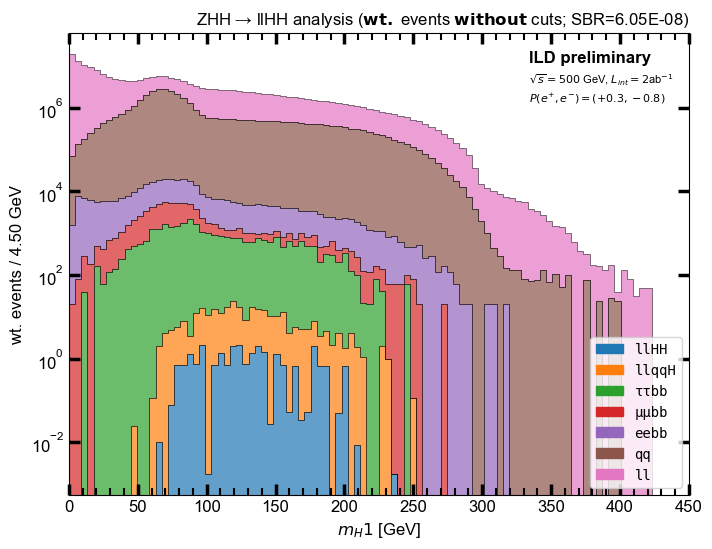

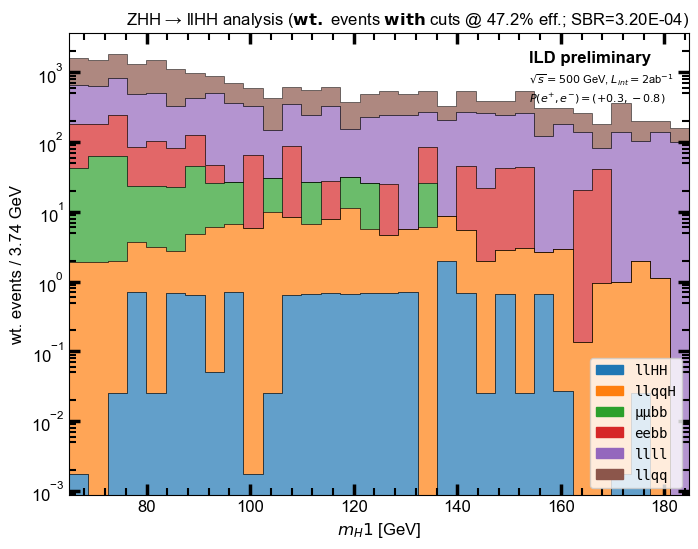

In [66]:
plot_lepton_preselection(presel_results, weights, category_map_inv, processes)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

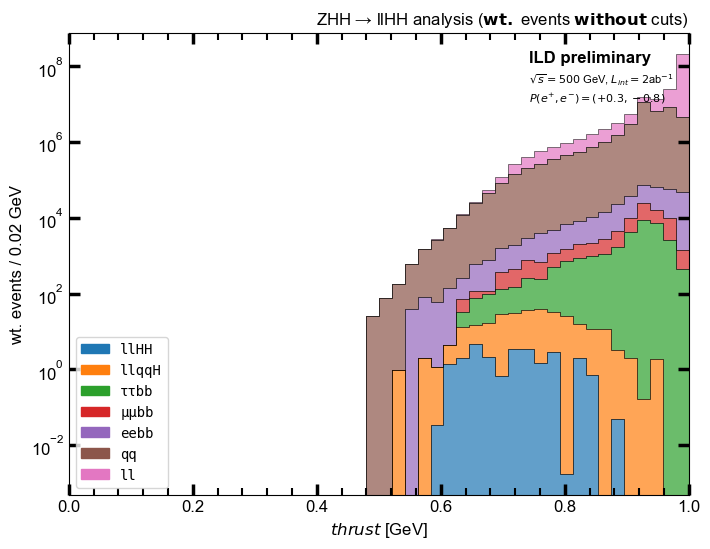

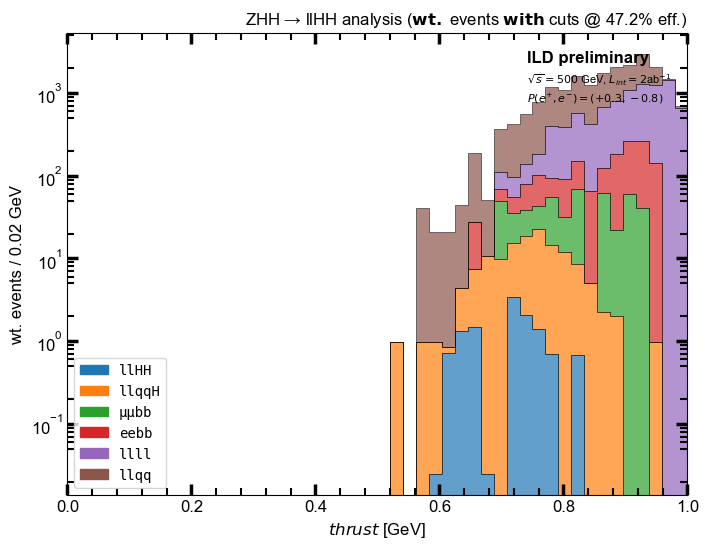

In [41]:
mH = 125
mZ = 91.2
mH_maxDiff = 60
mZ_maxDiff = 40

signal_categories = [11]

all_figs = []

mask_start = np.ones(len(presel_results), dtype=bool) # (presel_results['ll_mz'] > 0)
mask_end   = (presel_results['ll_mz'] > 0) & (presel_results['xx_nisoleps'] >= 2 ) & (np.abs(presel_results['ll_mz'] - mZ) < mZ_maxDiff) & \
        (np.abs(presel_results['ll_mh1'] - mH) < mH_maxDiff) & (np.abs(presel_results['ll_mh2'] - mH) < mH_maxDiff)
        
for fig in plot_cut_efficiency(presel_results, [mask_start, mask_end], weights, signal_categories, category_map_inv, processes,
                                'xx_thrust', 'GeV', event_categories=[11, 16, 12, 13, 14], xlabel='thrust', xlim=(0, 1.), nbins=48,
                                ild_style_kwargs={'legend_kwargs': { 'loc': 'lower left' }}, with_sbr=False):
    all_figs.append(fig)

In [107]:
xlim=(0, 650.)

calc_dict = calc_preselection_by_event_categories(presel_results, processes, weights, category_map_inv, 'llHH', True, 'll_mz',
                                                  event_categories=[11, 16, 12, 13, 14], additional_event_categories=27)[0]

categories = np.array(list(calc_dict.keys()))
counts = np.zeros(len(categories), dtype=float)

for i, cat in enumerate(categories):
    counts[i] = calc_dict[cat][1].sum()
    
mask = np.argsort(-counts)
categories = categories[mask]
counts = counts[mask]

  0%|          | 0/32 [00:00<?, ?it/s]

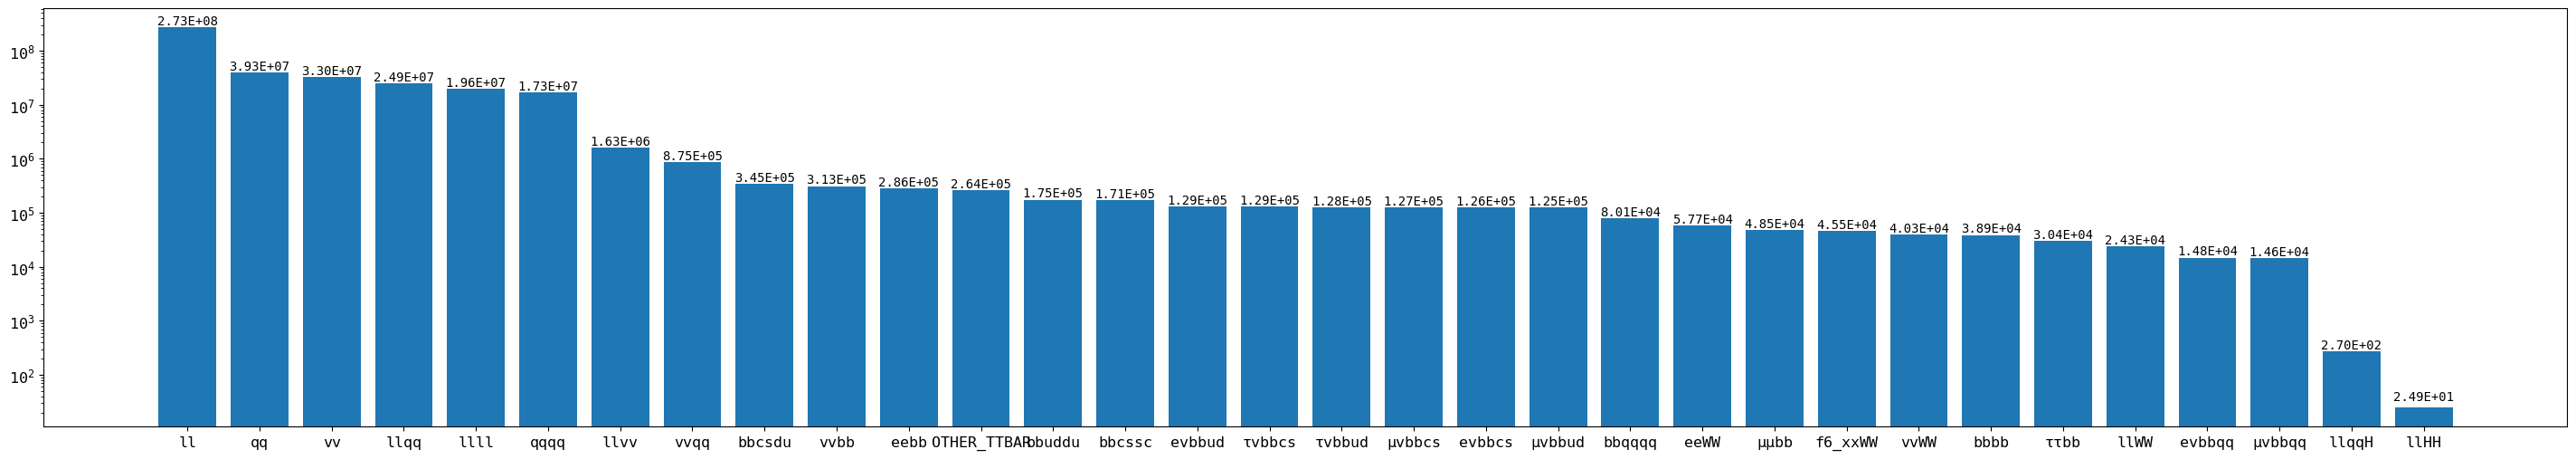

In [108]:
fig, ax = plt.subplots(figsize=(36, 6))

ax.bar(categories, counts)
ax.set_yscale('log')
rects = ax.patches

for rect, count in zip(rects, counts):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, f'{count:.2E}', ha="center", va="bottom"
    )

plt.show()

In [117]:
module_reload('zhh')
from zhh import get_final_state_counts, final_state_stack

#fsc = get_final_state_counts(f'{REPO_ROOT}/PreselectionFinal/v1', [0,1], chunks_f)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
fsc

In [119]:
fsc.nbytes

179125

In [70]:
def test(i):
    return np.sum(presel_results['ll_mh1'][presel_results['pid'] == i])

%timeit for i in range(len(processes)): test(i)

17.7 s ± 603 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


  0%|          | 0/10 [00:00<?, ?it/s]

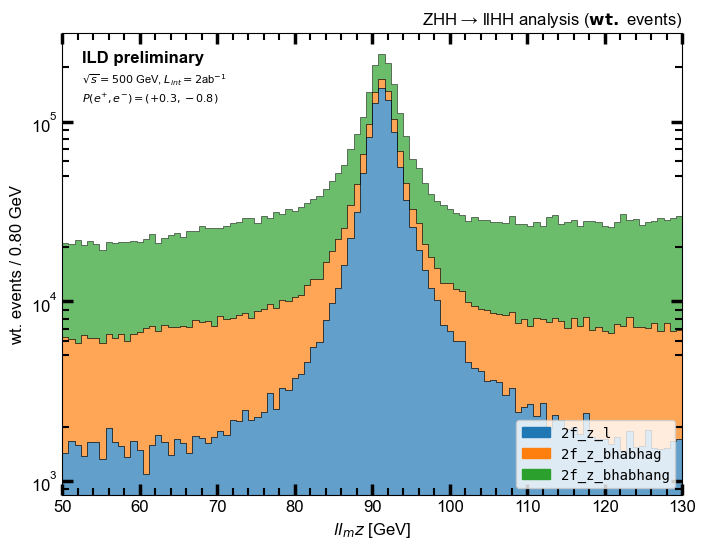

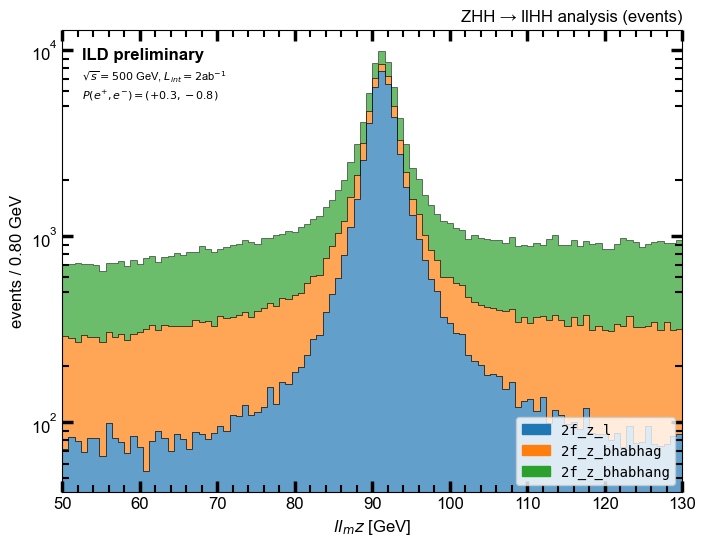

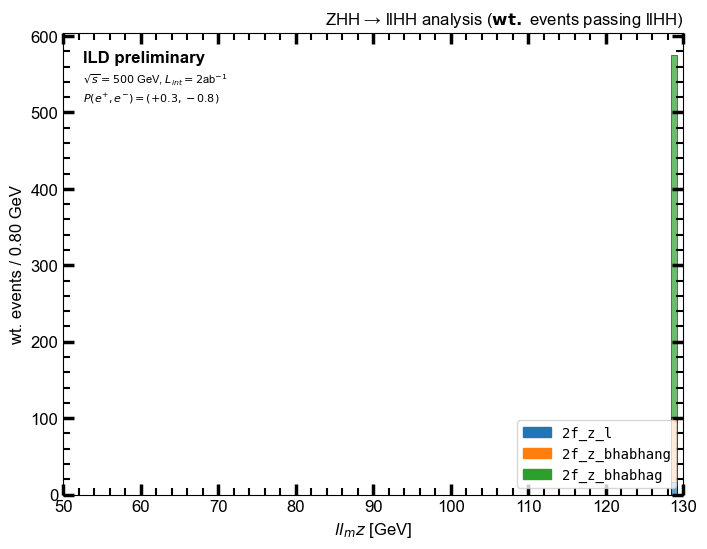

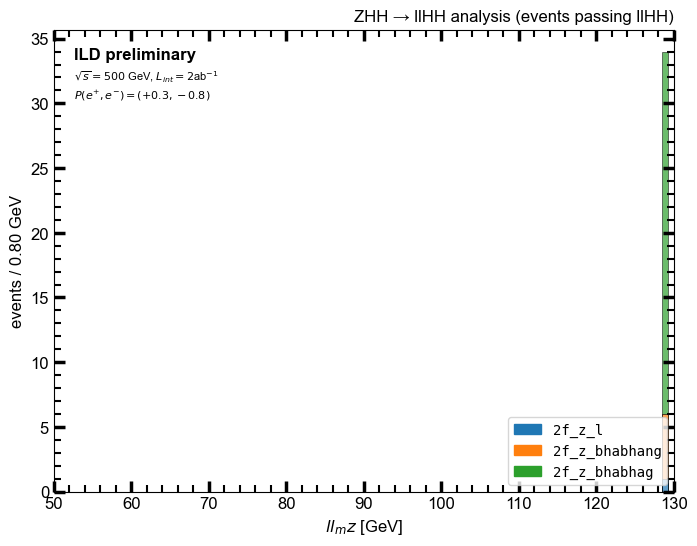

In [119]:
module_reload('zhh')
from zhh import plot_preselection_by_event_category

hypothesis = 'llHH'

plot_preselection_by_event_category(presel_results[presel_results['ll_mz'] > 0], processes, weights, hypothesis, [17], xlim=(50, 130),
                                    );

In [41]:
if False:
    presel_results = np.load(f'/nfs/dust/ilc/user/bliewert/zhh/PreselectionSummary/v1/presel_results.npy')
    weights = np.load(f'/nfs/dust/ilc/user/bliewert/zhh/PreselectionSummary/v1/presel_weights.npy')
else:
    np.save(f'{REPO_ROOT}/presel_results.npy', presel_results)
    np.save(f'{REPO_ROOT}/presel_weights.npy', weights)

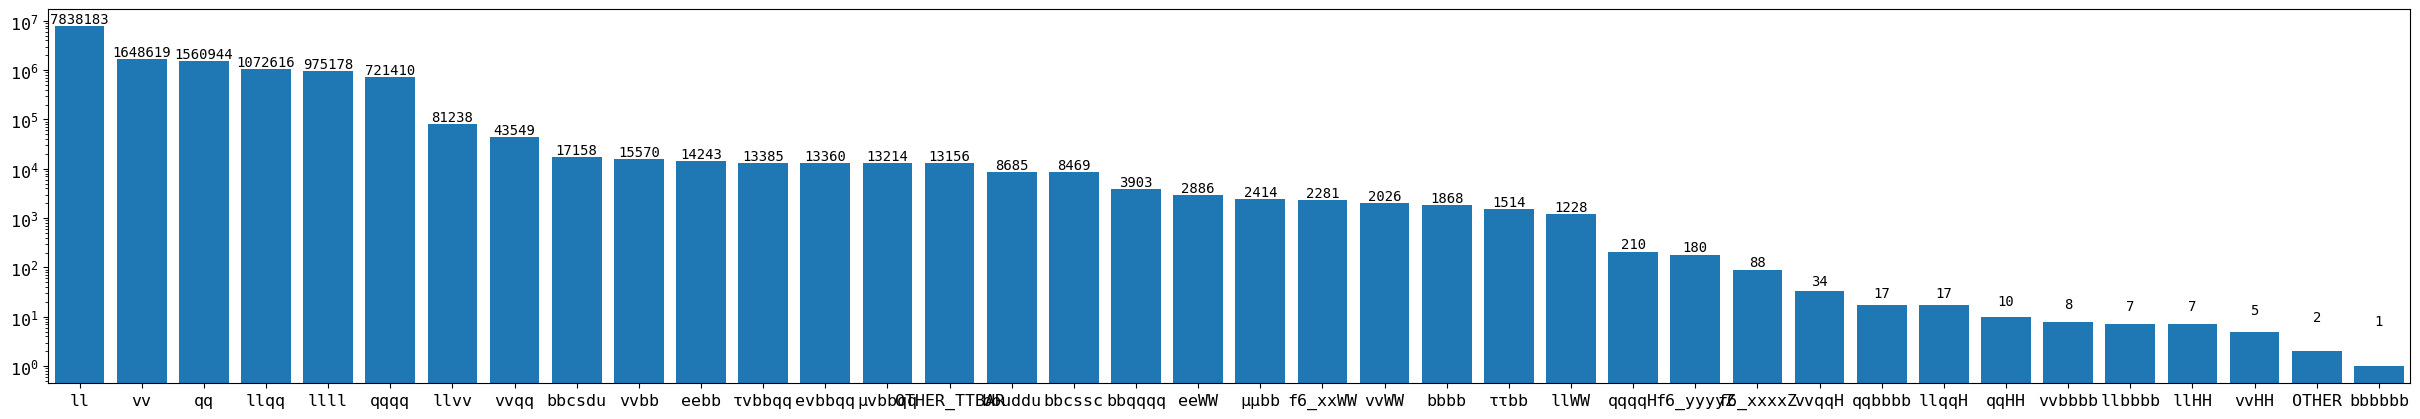

In [25]:
unq_cat, unq_counts = np.unique(presel_results['event_category'], return_counts=True)
mask = np.argsort(-unq_counts)

unq_cat = unq_cat[mask]
unq_counts = unq_counts[mask]
cat_counts = dict(zip(unq_cat, unq_counts))
unq_labels = category_arr['name'][np.isin(category_arr['evt_cat'], unq_cat)][mask]

fig, ax = plt.subplots(figsize=(24, 4))

ax.bar(unq_labels, unq_counts)
for rect, label in zip(ax.patches, unq_counts):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
    
ax.set_yscale('log')
ax.set_xlim(-0.5, len(unq_labels)-.5)
fig.set_tight_layout({"pad": .0})

In [29]:
unq_processes = np.unique(processes['process'])
expected_events = np.zeros(len(unq_processes), dtype=[('process', '<U60'), ('evt_expeceted', 'f')])
expected_events['process'] = unq_processes

for process_name in unq_processes:
    for process in processes[processes['process'] == process_name]:
        weight = weights['weight'][weights['pid'] == process['pid']][0]
        expected_events['evt_expeceted'][expected_events['process'] == process_name] += np.sum(chunks_f['chunk_size_factual'][chunks_f['proc_pol'] == process['proc_pol']])*weight
        
res = 0.
for process_name in ['e1e1hh', 'e2e2hh', 'e3e3hh']:
    res += expected_events['evt_expeceted'][expected_events['process'] == process_name][0]

print(f'expected llHH: {res:.2f} events')

expected llHH: 41.17 events


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

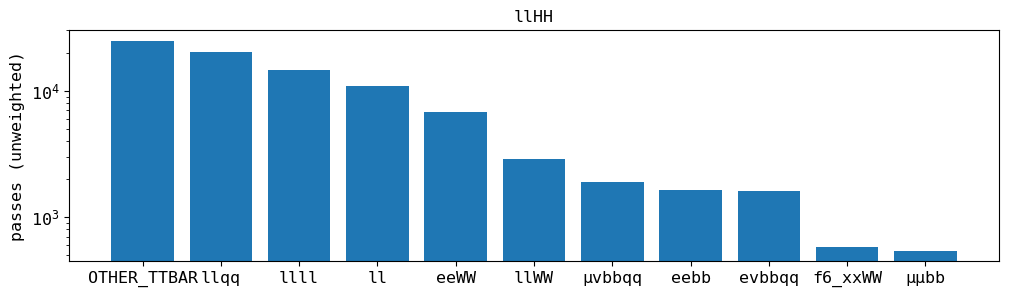

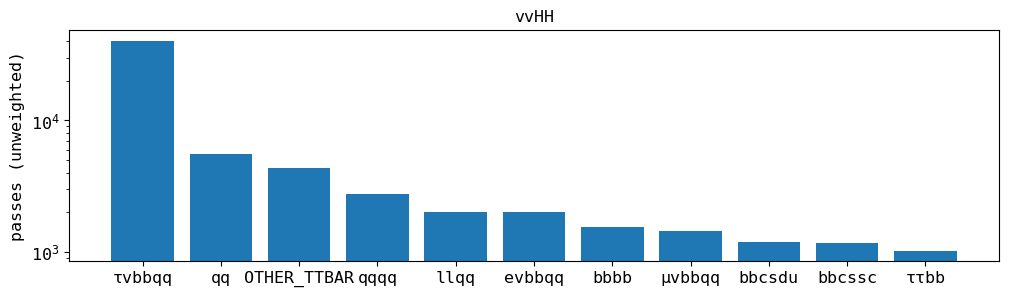

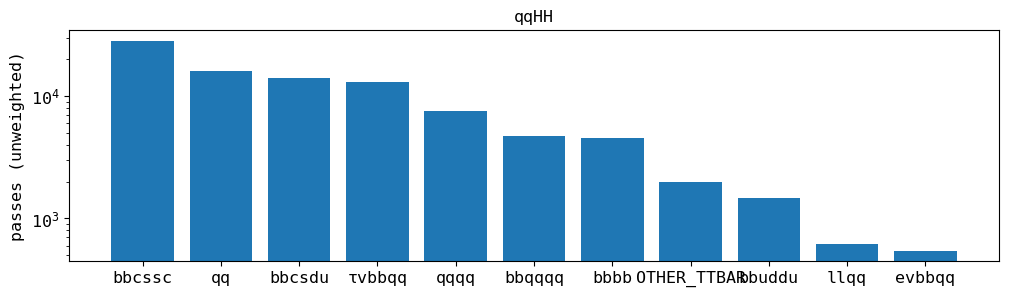

In [26]:
#event_categories = event_categories[event_categories != 0]
per_cat = {}

for presel in ['ll', 'vv', 'qq']:
    dtype = [
        ('category', 'i'),
        ('passes', 'f')
    ]
    passes_per_cat = np.zeros(len(unq_cat), dtype=dtype)
    passes_per_cat['category'] = unq_cat
    
    i = 0
    for category in tqdm(unq_cat):
        passes_per_cat[i]['category'] = category
        events = presel_results[presel_results['event_category'] == category]
        
        res = 0.
        for pid in np.unique(events['pid']):
            subset = events[events['pid'] == pid]
            res += np.sum(subset[f'{presel}_pass'] == 1) * weights['weight'][weights['pid'] == pid][0]
        
        passes_per_cat[i]['passes'] = res #/ cat_counts[category]
        
        i += 1
            
    per_cat[presel] = passes_per_cat
        
    sorted = passes_per_cat[np.argsort(-passes_per_cat['passes'])][:11]
    categories = []
    for s in sorted:
        categories.append(category_map_inv[s['category']])
    
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.bar(categories, sorted['passes'])
    ax.set_title(f'{presel}HH')
    ax.set_yscale('log')
    ax.set_ylabel('passes (unweighted)')

In [24]:
presel_results[presel_results['event_category'] == category_map['OTHER']]

array([(13569, 259, 0, 0, 0, 0, 0), (13570, 262, 0, 0, 0, 0, 0)],
      dtype=[('branch', '<i4'), ('pid', '<u2'), ('event', '<u4'), ('event_category', 'u1'), ('ll_pass', 'u1'), ('vv_pass', 'u1'), ('qq_pass', 'u1')])

In [27]:
pres = presel_results[presel_results['event_category'] == category_map['OTHER_TTBAR']]
subset = pres[['branch', 'event']]

In [29]:
branches = np.unique(subset['branch'])
print(len(branches))

1441
